In [1]:
import os
HOME = os.getcwd()
print(HOME)

/Users/diyaneupane/Downloads/vehiche_counting


In [2]:
!pip install ultralytics==8.3.19

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics 8.3.19 🚀 Python-3.10.9 torch-2.5.1 CPU (Apple M1)
Setup complete ✅ (8 CPUs, 16.0 GB RAM, 206.3/228.3 GB disk)


In [3]:
!pip install "supervision[assets]==0.24.0"



from IPython import display
display.clear_output()

import supervision as sv
print("supervision.__version__:", sv.__version__)

supervision.__version__: 0.24.0


In [6]:
from supervision.assets import download_assets, VideoAssets

SOURCE_VIDEO_PATH = download_assets(VideoAssets.VEHICLES)

vehicles.mp4 asset download complete. 



In [43]:
SOURCE_VIDEO_PATH = f"{HOME}/captured2.mp4"

In [4]:
from ultralytics import YOLO

model = YOLO("detect2/train/weights/best.pt")

In [5]:
CLASS_NAMES_DICT = model.model.names
print(CLASS_NAMES_DICT)

{0: '2', 1: '3', 2: '5', 3: '7'}


In [6]:
# Mapping of class_id to class_name
for class_id, class_name in CLASS_NAMES_DICT.items():
    print(f"Class ID: {class_id}, Class Name: {class_name}")



Class ID: 0, Class Name: 2
Class ID: 1, Class Name: 3
Class ID: 2, Class Name: 5
Class ID: 3, Class Name: 7


In [42]:
import cv2
VIDEO_DURATION = 10  # seconds
FRAME_RATE = 30
VIDEO_NAME = "captured2.mp4"
VIDEO_PATH = os.path.join(HOME, VIDEO_NAME)

# Capture video from the laptop camera
cap = cv2.VideoCapture(0)
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(VIDEO_PATH, fourcc, FRAME_RATE, (frame_width, frame_height))

frame_count = 0
while frame_count < VIDEO_DURATION * FRAME_RATE:
    ret, frame = cap.read()
    if not ret:
        break
    out.write(frame)
    frame_count += 1

cap.release()
out.release()

print(f"Video saved at {VIDEO_PATH}")


Video saved at /Users/diyaneupane/Downloads/vehiche_counting/captured2.mp4


In [34]:
import supervision as sv
import numpy as np

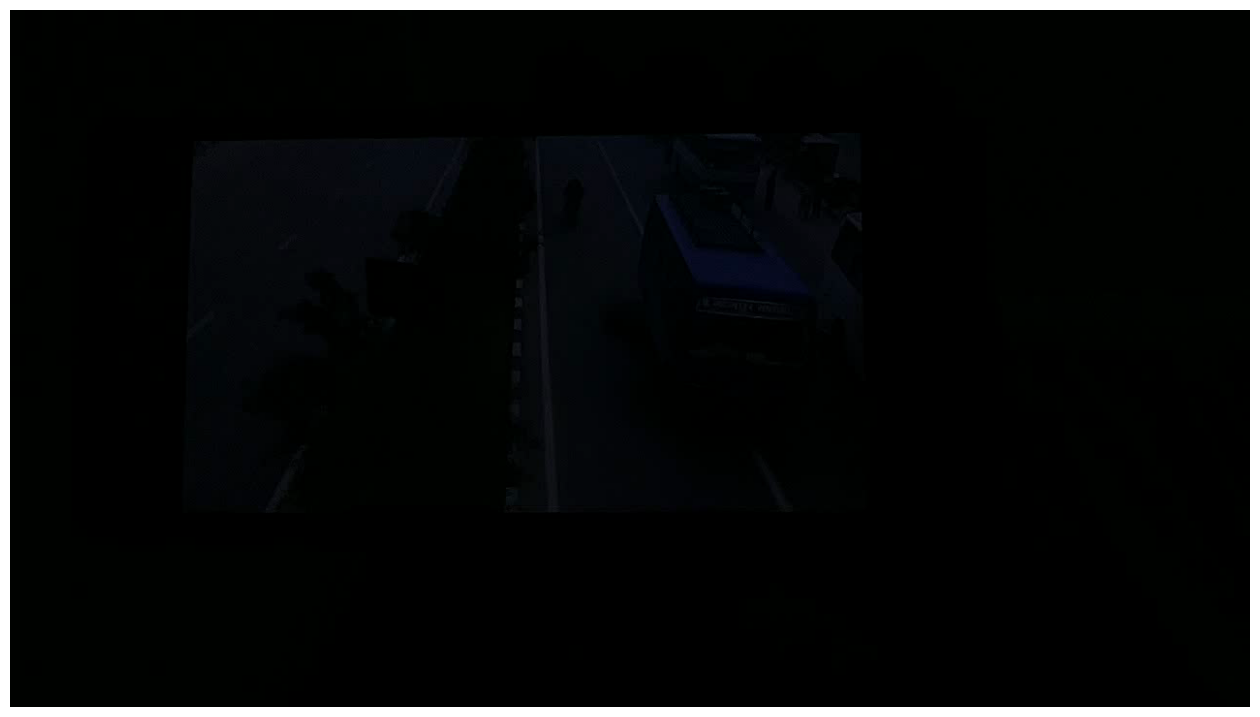

In [23]:
# create frame generator
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
# create instance of BoxAnnotator and LabelAnnotator
box_annotator = sv.BoxAnnotator(thickness=2)
label_annotator = sv.LabelAnnotator(text_thickness=1, text_scale=1, text_color=sv.Color.BLACK)
# acquire first video frame
iterator = iter(generator)
frame = next(iterator)
# model prediction on single frame and conversion to supervision Detections
results = model(frame, verbose=False)[0]

# convert to Detections
detections = sv.Detections.from_ultralytics(results)



# format custom labels
labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
    for confidence, class_id in zip(detections.confidence, detections.class_id)
]

# annotate and display frame
annotated_frame = frame.copy()
annotated_frame = box_annotator.annotate(
    scene=annotated_frame, detections=detections)
annotated_frame = label_annotator.annotate(
    scene=annotated_frame, detections=detections, labels=labels)

%matplotlib inline
sv.plot_image(annotated_frame, (16, 16))

In [44]:
LINE_START = sv.Point(0 + 50, 1500)
LINE_END = sv.Point(3840 - 50, 1500)

TARGET_VIDEO_PATH = f"{HOME}/captured_result2.mp4"

In [45]:
sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

VideoInfo(width=1280, height=720, fps=30, total_frames=300)

In [46]:
# create BYTETracker instance
byte_tracker = sv.ByteTrack(
    track_activation_threshold=0.25,
    lost_track_buffer=30,
    minimum_matching_threshold=0.8,
    frame_rate=30,
    minimum_consecutive_frames=3)

byte_tracker.reset()

# create VideoInfo instance
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

# create frame generator
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

# create LineZone instance, it is previously called LineCounter class
line_zone = sv.LineZone(start=LINE_START, end=LINE_END)

# create instance of BoxAnnotator, LabelAnnotator, and TraceAnnotator
box_annotator = sv.BoxAnnotator(thickness=4)
label_annotator = sv.LabelAnnotator(text_thickness=2, text_scale=1.5, text_color=sv.Color.BLACK)
trace_annotator = sv.TraceAnnotator(thickness=4, trace_length=50)

# create LineZoneAnnotator instance, it is previously called LineCounterAnnotator class
line_zone_annotator = sv.LineZoneAnnotator(thickness=4, text_thickness=4, text_scale=2)

# define call back function to be used in video processing
def callback(frame: np.ndarray, index: int) -> np.ndarray:
    # model prediction on single frame and conversion to supervision Detections
    results = model(frame, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)
    # only consider class id from selected_classes define above

    # tracking detections
    detections = byte_tracker.update_with_detections(detections)
    labels = [
        f"#{tracker_id} {model.model.names[class_id]} {confidence:0.2f}"
        for confidence, class_id, tracker_id
        in zip(detections.confidence, detections.class_id, detections.tracker_id)
    ]
    annotated_frame = frame.copy()
    annotated_frame = trace_annotator.annotate(
        scene=annotated_frame, detections=detections)
    annotated_frame = box_annotator.annotate(
        scene=annotated_frame, detections=detections)
    annotated_frame = label_annotator.annotate(
        scene=annotated_frame, detections=detections, labels=labels)

    # update line counter
    line_zone.trigger(detections)
    # return frame with box and line annotated result
    return line_zone_annotator.annotate(annotated_frame, line_counter=line_zone)

# process the whole video
sv.process_video(
    source_path = SOURCE_VIDEO_PATH,
    target_path = TARGET_VIDEO_PATH,
    callback=callback
)